# Spark MLlib Exercises


http://spark.apache.org/docs/latest/ml-statistics.html

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/19 17:09:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

## 1. Statistics (1p.)

Download the following dataset: https://www.kaggle.com/c/titanic/data?select=train.csv

In [3]:
file = "titanic_train.csv"
titanic_df = spark.read.format("csv").options(inferSchema="true", header="true").load(file)
titanic_df = titanic_df.dropna(how='any')
titanic_df.show(10)
print(titanic_df.dtypes)

+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+-----------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket|   Fare|      Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+-----------+--------+
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|PC 17599|71.2833|        C85|       C|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|  113803|   53.1|       C123|       S|
|          7|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|   17463|51.8625|        E46|       S|
|         11|       1|     3|Sandstrom, Miss. ...|female| 4.0|    1|    1| PP 9549|   16.7|         G6|       S|
|         12|       1|     1|Bonnell, Miss. El...|female|58.0|    0|    0|  113783|  26.55|       C103|       S|
|         22|       1|     2|Beesley, Mr. Lawr...|  male|34.0|    0|    0|  248698|   13.0|     

### Exercise 1.A.
**TODO:** Calculate descriptive statistics for 'Age' and 'Fare' (see https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/sql/DataFrame.html#describe(scala.collection.Seq))

In [4]:
titanic_df.describe("Age", "Fare").show()

+-------+------------------+-----------------+
|summary|               Age|             Fare|
+-------+------------------+-----------------+
|  count|               183|              183|
|   mean|  35.6744262295082|78.68246885245901|
| stddev|15.643865966849717|76.34784270040569|
|    min|              0.92|              0.0|
|    max|              80.0|         512.3292|
+-------+------------------+-----------------+



### Exercise 1.B.

**TODO:** Check if 'Age' and 'Fare' have normal distribution (see http://spark.apache.org/docs/latest/api/java/org/apache/spark/ml/stat/KolmogorovSmirnovTest.html)

In [5]:
from pyspark.ml.stat import KolmogorovSmirnovTest
from pyspark.sql.functions import mean, stddev, col

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

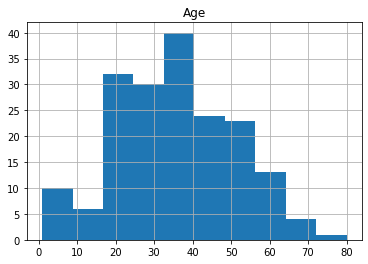

In [6]:
Age = titanic_df.select('Age').toPandas()

Age.hist()

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

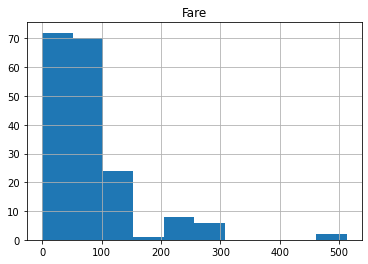

In [7]:
Fare = titanic_df.select('Fare').toPandas()

Fare.hist()

In [8]:
mean_age = titanic_df.agg(mean(col("Age"))).first()[0]
std_age = titanic_df.agg(stddev(col("Age"))).first()[0]
mean_fare = titanic_df.agg(mean(col("Fare"))).first()[0]
std_fare = titanic_df.agg(stddev(col("Fare"))).first()[0]

In [9]:
KolmogorovSmirnovTest.test(titanic_df, 'Age', 'norm', mean_age, std_age).first()

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Row(pValue=0.8522382560293139, statistic=0.04414417432750317)

Nie ma podstaw żeby mówić że nie

In [10]:
KolmogorovSmirnovTest.test(titanic_df, 'Fare', 'norm', mean_fare, std_fare).first()

Row(pValue=6.282326284745565e-07, statistic=0.2005338889924242)

Prawie na pewno nie

### Exercise 1.C.

**TODO:** Calculate Pearson correlation between the following pairs of features:  
* 'Age' and 'Survived'
* 'Sex' and 'Survived' *(remember about encoding 'Sex' attributes as 0s and 1s)*

Which correlation is stronger?

In [11]:
from pyspark.sql.functions import udf

In [12]:
def to_onehot(x):
    if x == 'female':
        return 1
    elif x == 'male':
        return 0
    else:
        return x

to_onehot_udf = udf(to_onehot)

titanic_df = titanic_df.withColumn("Sex", to_onehot_udf(col("Sex")).cast('double'))

In [13]:
titanic_df.first()

Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex=1.0, Age=38.0, SibSp=1, Parch=0, Ticket='PC 17599', Fare=71.2833, Cabin='C85', Embarked='C')

In [14]:
titanic_df.stat.corr("Sex","Survived")

0.5324179744538412

In [15]:
titanic_df.stat.corr("Age","Survived")

-0.2540847542030532

Znacznie sielniejsza korelacja występuje w przypadku płci

## 2. Loading data

Doc: http://spark.apache.org/docs/latest/ml-datasource.html 

Download data from https://github.com/apache/spark/blob/master/data/mllib/sample_libsvm_data.txt and load as DataFrame. 

In [16]:
file = "sample_libsvm_data.txt"

libsvm_df = spark.read.format("libsvm").option("numFeatures", "780").load(file)
libsvm_df.show(10)
libsvm_df.take(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(780,[127,128,129...|
|  1.0|(780,[158,159,160...|
|  1.0|(780,[124,125,126...|
|  1.0|(780,[152,153,154...|
|  1.0|(780,[151,152,153...|
|  0.0|(780,[129,130,131...|
|  1.0|(780,[158,159,160...|
|  1.0|(780,[99,100,101,...|
|  0.0|(780,[154,155,156...|
|  0.0|(780,[127,128,129...|
+-----+--------------------+
only showing top 10 rows



[Row(label=0.0, features=SparseVector(780, {127: 51.0, 128: 159.0, 129: 253.0, 130: 159.0, 131: 50.0, 154: 48.0, 155: 238.0, 156: 252.0, 157: 252.0, 158: 252.0, 159: 237.0, 181: 54.0, 182: 227.0, 183: 253.0, 184: 252.0, 185: 239.0, 186: 233.0, 187: 252.0, 188: 57.0, 189: 6.0, 207: 10.0, 208: 60.0, 209: 224.0, 210: 252.0, 211: 253.0, 212: 252.0, 213: 202.0, 214: 84.0, 215: 252.0, 216: 253.0, 217: 122.0, 235: 163.0, 236: 252.0, 237: 252.0, 238: 252.0, 239: 253.0, 240: 252.0, 241: 252.0, 242: 96.0, 243: 189.0, 244: 253.0, 245: 167.0, 262: 51.0, 263: 238.0, 264: 253.0, 265: 253.0, 266: 190.0, 267: 114.0, 268: 253.0, 269: 228.0, 270: 47.0, 271: 79.0, 272: 255.0, 273: 168.0, 289: 48.0, 290: 238.0, 291: 252.0, 292: 252.0, 293: 179.0, 294: 12.0, 295: 75.0, 296: 121.0, 297: 21.0, 300: 253.0, 301: 243.0, 302: 50.0, 316: 38.0, 317: 165.0, 318: 253.0, 319: 233.0, 320: 208.0, 321: 84.0, 328: 253.0, 329: 252.0, 330: 165.0, 343: 7.0, 344: 178.0, 345: 252.0, 346: 240.0, 347: 71.0, 348: 19.0, 349: 28.0

### Exercise 2.A
**TODO:** Load wine data from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/wine.scale
Dataset description: http://archive.ics.uci.edu/ml/datasets/Wine

In [17]:
file = "wine.scale"

winedf = spark.read.format("libsvm").load(file)
winedf.show(10)
winedf.take(1)

21/12/19 17:09:25 WARN LibSVMFileFormat: 'numFeatures' option not specified, determining the number of features by going though the input. If you know the number in advance, please specify it via 'numFeatures' option to avoid the extra scan.


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
|  1.0|(13,[0,1,2,3,4,5,...|
+-----+--------------------+
only showing top 10 rows



[Row(label=1.0, features=SparseVector(13, {0: 0.6842, 1: -0.6166, 2: 0.1444, 3: -0.4845, 4: 0.2391, 5: 0.2552, 6: 0.1477, 7: -0.434, 8: 0.1861, 9: -0.256, 10: -0.0894, 11: 0.9414, 12: 0.1227}))]

## 3. Classification (2p.)

In [18]:
file = "wine.csv" # https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv

# Remember about deleting dots from the headers of this csv file!
winedf2 = spark.read.format("csv").options(inferSchema="true", header="true").load(file)
winedf2.show(10)
print(winedf2.dtypes)

+----+-------+----------+----+----+---+-------+----------+--------------------+-------+---------+----+----+-------+
|Wine|Alcohol|Malic.acid| Ash| Acl| Mg|Phenols|Flavanoids|Nonflavanoid.phenols|Proanth|Color.int| Hue|  OD|Proline|
+----+-------+----------+----+----+---+-------+----------+--------------------+-------+---------+----+----+-------+
|   1|  14.23|      1.71|2.43|15.6|127|    2.8|      3.06|                0.28|   2.29|     5.64|1.04|3.92|   1065|
|   1|   13.2|      1.78|2.14|11.2|100|   2.65|      2.76|                0.26|   1.28|     4.38|1.05| 3.4|   1050|
|   1|  13.16|      2.36|2.67|18.6|101|    2.8|      3.24|                 0.3|   2.81|     5.68|1.03|3.17|   1185|
|   1|  14.37|      1.95| 2.5|16.8|113|   3.85|      3.49|                0.24|   2.18|      7.8|0.86|3.45|   1480|
|   1|  13.24|      2.59|2.87|21.0|118|    2.8|      2.69|                0.39|   1.82|     4.32|1.04|2.93|    735|
|   1|   14.2|      1.76|2.45|15.2|112|   3.27|      3.39|              

### Exercise 3.A
**TODO:** 

Remember about deleting dots from the headers of this csv file and splitting data into train and test set


1) Create pipeline with VectorAssembler and DecisionTreeClassifier.

2) Use the pipeline to make predictions.

3) Evaluate predictions using MulticlassClassificationEvaluator.

4) Calculate accuracy and test error

5) Print the structure of the trained decision tree (hint: use toDebugString attribute)

In [19]:
winedf2 = winedf2.withColumnRenamed("Malic.acid", "Malic_acid")\
       .withColumnRenamed("Nonflavanoid.phenols", "Nonflavanoid_phenols")\
       .withColumnRenamed("Color.int", "Color_int")

In [20]:
winedf2.first()

Row(Wine=1, Alcohol=14.23, Malic_acid=1.71, Ash=2.43, Acl=15.6, Mg=127, Phenols=2.8, Flavanoids=3.06, Nonflavanoid_phenols=0.28, Proanth=2.29, Color_int=5.64, Hue=1.04, OD=3.92, Proline=1065)

In [21]:
winedf2.columns

['Wine',
 'Alcohol',
 'Malic_acid',
 'Ash',
 'Acl',
 'Mg',
 'Phenols',
 'Flavanoids',
 'Nonflavanoid_phenols',
 'Proanth',
 'Color_int',
 'Hue',
 'OD',
 'Proline']

In [22]:
(train, test) = winedf2.randomSplit([0.7, 0.3])

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, QuantileDiscretizer

In [24]:
assembler = VectorAssembler(
    inputCols=['Alcohol',
 'Malic_acid',
 'Ash',
 'Acl',
 'Mg',
 'Phenols',
 'Flavanoids',
 'Nonflavanoid_phenols',
 'Proanth',
 'Color_int',
 'Hue',
 'OD',
 'Proline'],
    outputCol='features')

In [25]:
dt = DecisionTreeClassifier(labelCol="Wine", featuresCol="features")

In [26]:
pipeline = Pipeline(stages=[assembler, dt])

In [27]:
model = pipeline.fit(train)

In [28]:
predictions = model.transform(test)

In [29]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="Wine", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {}".format(accuracy))
print("Error: {}".format(1.0 - accuracy))


Accuracy: 0.8979591836734694
Error: 0.10204081632653061


In [30]:
print(model.stages[1].toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_665b413fd3e3, depth=4, numNodes=13, numClasses=4, numFeatures=13
  If (feature 9 <= 3.9699999999999998)
   If (feature 12 <= 953.5)
    Predict: 2.0
   Else (feature 12 > 953.5)
    If (feature 0 <= 13.06)
     Predict: 2.0
    Else (feature 0 > 13.06)
     Predict: 1.0
  Else (feature 9 > 3.9699999999999998)
   If (feature 6 <= 1.5750000000000002)
    Predict: 3.0
   Else (feature 6 > 1.5750000000000002)
    If (feature 12 <= 682.5)
     If (feature 0 <= 13.135)
      Predict: 2.0
     Else (feature 0 > 13.135)
      Predict: 1.0
    Else (feature 12 > 682.5)
     Predict: 1.0



### Exercise 3.B
**TODO:** 

1) Extend the pipeline from the previos task with QuantileDiscretizer 

2) Try using a couple of different numbers of buckets, which cinfiguration gives the best results?

3) Can you see any difference in the structure of the decistion tree?

In [31]:
cols = ['Alcohol',
 'Malic_acid',
 'Ash',
 'Acl',
 'Mg',
 'Phenols',
 'Flavanoids',
 'Nonflavanoid_phenols',
 'Proanth',
 'Color_int',
 'Hue',
 'OD',
 'Proline']

cols_q = [c+'_q' for c in cols]

assembler = VectorAssembler(
    inputCols=cols_q,
    outputCol='features')

In [32]:
pipeline3 = Pipeline(stages=[QuantileDiscretizer(numBuckets=3, inputCols=cols, outputCols=cols_q),
                            assembler, dt])
pipeline5 = Pipeline(stages=[QuantileDiscretizer(numBuckets=5, inputCols=cols, outputCols=cols_q),
                            assembler, dt])
pipeline10 = Pipeline(stages=[QuantileDiscretizer(numBuckets=10, inputCols=cols, outputCols=cols_q),
                            assembler, dt])

In [33]:
model = pipeline3.fit(train)
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(
    labelCol="Wine", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy3: {}".format(accuracy))
print("Error3: {}".format(1.0 - accuracy))

Accuracy3: 0.8163265306122449
Error3: 0.18367346938775508


In [34]:
print(model.stages[2].toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_665b413fd3e3, depth=5, numNodes=17, numClasses=4, numFeatures=13
  If (feature 9 in {0.0})
   If (feature 3 in {0.0})
    If (feature 4 in {1.0})
     Predict: 1.0
    Else (feature 4 not in {1.0})
     Predict: 2.0
   Else (feature 3 not in {0.0})
    Predict: 2.0
  Else (feature 9 not in {0.0})
   If (feature 6 in {0.0})
    Predict: 3.0
   Else (feature 6 not in {0.0})
    If (feature 12 in {0.0,1.0})
     If (feature 3 in {0.0})
      If (feature 2 in {0.0})
       Predict: 2.0
      Else (feature 2 not in {0.0})
       Predict: 1.0
     Else (feature 3 not in {0.0})
      If (feature 1 in {0.0,1.0})
       Predict: 2.0
      Else (feature 1 not in {0.0,1.0})
       Predict: 3.0
    Else (feature 12 not in {0.0,1.0})
     Predict: 1.0



In [35]:
model = pipeline5.fit(train)
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(
    labelCol="Wine", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy5: {}".format(accuracy))
print("Error5: {}".format(1.0 - accuracy))

Accuracy5: 0.8571428571428571
Error5: 0.1428571428571429


In [36]:
print(model.stages[2].toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_665b413fd3e3, depth=5, numNodes=17, numClasses=4, numFeatures=13
  If (feature 0 in {0.0,1.0})
   If (feature 11 in {0.0})
    Predict: 3.0
   Else (feature 11 not in {0.0})
    Predict: 2.0
  Else (feature 0 not in {0.0,1.0})
   If (feature 6 in {0.0,1.0})
    If (feature 3 in {0.0})
     Predict: 2.0
    Else (feature 3 not in {0.0})
     Predict: 3.0
   Else (feature 6 not in {0.0,1.0})
    If (feature 12 in {0.0,1.0,2.0})
     If (feature 4 in {0.0,1.0})
      Predict: 2.0
     Else (feature 4 not in {0.0,1.0})
      Predict: 1.0
    Else (feature 12 not in {0.0,1.0,2.0})
     If (feature 3 in {0.0,1.0,2.0,3.0})
      Predict: 1.0
     Else (feature 3 not in {0.0,1.0,2.0,3.0})
      If (feature 0 in {2.0})
       Predict: 2.0
      Else (feature 0 not in {2.0})
       Predict: 1.0



In [37]:
model = pipeline10.fit(train)
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(
    labelCol="Wine", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy10: {}".format(accuracy))
print("Error10: {}".format(1.0 - accuracy))

Accuracy10: 0.8775510204081632
Error10: 0.12244897959183676


In [38]:
print(model.stages[2].toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_665b413fd3e3, depth=5, numNodes=15, numClasses=4, numFeatures=13
  If (feature 9 in {0.0,1.0,2.0})
   Predict: 2.0
  Else (feature 9 not in {0.0,1.0,2.0})
   If (feature 10 in {0.0,1.0,2.0})
    If (feature 12 in {0.0})
     Predict: 2.0
    Else (feature 12 not in {0.0})
     Predict: 3.0
   Else (feature 10 not in {0.0,1.0,2.0})
    If (feature 12 in {1.0,2.0,3.0,4.0})
     If (feature 1 in {0.0,2.0,3.0,5.0})
      Predict: 2.0
     Else (feature 1 not in {0.0,2.0,3.0,5.0})
      Predict: 3.0
    Else (feature 12 not in {1.0,2.0,3.0,4.0})
     If (feature 12 in {6.0,7.0,8.0,9.0})
      Predict: 1.0
     Else (feature 12 not in {6.0,7.0,8.0,9.0})
      If (feature 0 in {2.0})
       Predict: 2.0
      Else (feature 0 not in {2.0})
       Predict: 3.0



## 4. Text classification (2p.)

### Exercise 4
**TODO:** 
Build a pipeline consisting of Tokenizer, HashingTF, IDF and StringIndexer and LogisticRegression, fit it to training data: 
http://help.sentiment140.com/for-students/

What is the accuracy of this classifier?

In [39]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

In [40]:
file = "training.1600000.processed.noemoticon.csv" # https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv

# Remember about deleting dots from the headers of this csv file!
train = spark.read.format("csv").options(inferSchema="true", header="False").load(file)
train.show(10)
print(train.dtypes)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  0|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [41]:
file = "testdata.manual.2009.06.14.csv" # https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv

# Remember about deleting dots from the headers of this csv file!
test = spark.read.format("csv").options(inferSchema="true", header="False").load(file)
test.show(10)
print(test.dtypes)

+---+---+--------------------+-------+------------+--------------------+
|_c0|_c1|                 _c2|    _c3|         _c4|                 _c5|
+---+---+--------------------+-------+------------+--------------------+
|  4|  3|Mon May 11 03:17:...|kindle2|      tpryan|@stellargirl I lo...|
|  4|  4|Mon May 11 03:18:...|kindle2|      vcu451|Reading my kindle...|
|  4|  5|Mon May 11 03:18:...|kindle2|      chadfu|Ok, first assesme...|
|  4|  6|Mon May 11 03:19:...|kindle2|       SIX15|@kenburbary You'l...|
|  4|  7|Mon May 11 03:21:...|kindle2|    yamarama|@mikefish  Fair e...|
|  4|  8|Mon May 11 03:22:...|kindle2|GeorgeVHulme|@richardebaker no...|
|  0|  9|Mon May 11 03:22:...|    aig|     Seth937|Fuck this economy...|
|  4| 10|Mon May 11 03:26:...| jquery|   dcostalis|Jquery is my new ...|
|  4| 11|Mon May 11 03:27:...|twitter|     PJ_King|       Loves twitter|
|  4| 12|Mon May 11 03:29:...|  obama| mandanicole|how can you not l...|
+---+---+--------------------+-------+------------+

In [42]:
train = train.withColumnRenamed("_c0", "label")\
       .withColumnRenamed("_c5", "text")

In [44]:
test = test.withColumnRenamed("_c0", "label")\
       .withColumnRenamed("_c5", "text")

In [45]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=5)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])


In [46]:
model = pipeline.fit(train.sample(fraction=0.1, seed=0))

21/12/19 17:09:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/19 17:09:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
21/12/19 17:09:37 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/19 17:09:37 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [47]:
predictions = model.transform(test)

In [49]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {}".format(accuracy))

21/12/19 17:09:54 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


Accuracy: 0.4859437751004016


In [53]:
test.select('label').distinct().collect()

[Row(label=4), Row(label=2), Row(label=0)]